In [1]:
import sys
sys.path.append("models/raster")

import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from auxiliary.visualization import visualize_confusion_matrix
from auxiliary.misc import get_model_name

from initialize_raster import load_trained_raster_model
from dataset_raster import BuildingRasterDataset
from metrics_raster import get_metrics_raster
from predict_raster import get_activations_raster
from thresholds_raster import raster_thresholds

from models.pr_roc import get_pr_roc, plot_pr_curve, plot_roc_curve
from models.operators import elimination_operators, selection_operators, threshold_dic_to_tensor

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    raster_path = "../scratch/raster"
else:
    device = torch.device("cpu")
    # local path
    raster_path = "../data.nosync/raster"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

In [5]:
def load_validation_test_raster_dataset(operator_model, operators_to_predict, attach_roads, subset):
    '''Loads the validation and test dataset for the given model.'''
    # define path to validation and test data
    path_to_validation_data = os.path.join(raster_path, "training_data", operator_model, "validation")
    path_to_test_data = os.path.join(raster_path, "training_data", operator_model, "test")

    # composing various random transforms that should be applied to the data
    transform = transforms.Compose([
        transforms.RandomChoice([
            transforms.RandomRotation(degrees=(0,0)),
            transforms.RandomRotation(degrees=(90,90)),
            transforms.RandomRotation(degrees=(180,180)),
            transforms.RandomRotation(degrees=(270,270))
        ]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5)
    ])
    
    # construct validation Dataset (no shuffling)
    validation_set = BuildingRasterDataset(path_to_validation_data, 
                                           operators=operators_to_predict, 
                                           attach_roads=attach_roads, 
                                           transform=transform,
                                           subset=subset)
    
    # construct test Dataset (no transformations, no shuffling)
    test_set = BuildingRasterDataset(path_to_test_data, 
                                     operators=operators_to_predict, 
                                     attach_roads=attach_roads, 
                                     transform=None,
                                     subset=subset)

    return validation_set, test_set

In [6]:
def compute_raster_evaluation_metrics(model_filename):
    '''Given the filename of a raster model, computes, saves and prints the accuracy metrics.'''
    operator_model_map = {"eli": "elimination", "sel": "selection"}
    
    # extract necessary information from model filename
    model_filename_split = model_filename.split("_")
    architecture = model_filename_split[0]
    operator_model = operator_model_map[model_filename_split[1]]
    operators_to_predict = elimination_operators if operator_model == "elimination" else selection_operators
    attach_roads = True if model_filename_split[2] == "attachRoadsTrue" else False
    n_training_samples = int(model_filename_split[-4][:-1])
    n_epochs = int(model_filename_split[-3][:-2])
    batch_size = int(model_filename_split[-2][2:])
    device_trained_on = model_filename_split[-1][:-4]

    # load the trained model
    model = load_trained_raster_model(model_filename, raster_path, device)
    print(model)

    # load test set
    _, test_set = load_validation_test_raster_dataset(operator_model=operator_model, 
                                                      operators_to_predict=operators_to_predict, 
                                                      attach_roads=attach_roads, 
                                                      subset=None)

    # get the thresholds determined through ROC and PR curves
    threshold = raster_thresholds[f"{architecture} {operator_model}"]
    if operator_model == "selection":
        threshold = threshold_dic_to_tensor(threshold)

    # calculate accuracy metrics
    metrics = get_metrics_raster(model=model, 
                                 dataset=test_set,
                                 batch_size=512,
                                 operators_to_pred=operators_to_predict, 
                                 threshold=threshold,
                                 device=device)

    # saving the accuracy metrics
    model_name = get_model_name(model, 
                                ops=model_filename_split[1], 
                                attach_roads=attach_roads, 
                                n_samples=n_training_samples, 
                                n_epochs=n_epochs, 
                                batch_size=batch_size,
                                device=device_trained_on) + ".csv"
    metrics_path = os.path.join(raster_path, "model_outputs", operator_model, "metrics", model_name)
    
    # creating a DataFrame with accuracy metrics
    metrics_df = pd.DataFrame({"operator": metrics["operator"],
                               "accuracy": metrics["accuracy"], 
                               "precision": metrics["precision"],
                               "recall": metrics["recall"],
                               "f1-score": metrics["f1_score"]})
    
    # save to CSV
    metrics_df.to_csv(metrics_path, index=False)
    
    # print the results
    for i in range(len(operators_to_predict)):
        # display the confusion matrix
        visualize_confusion_matrix(metrics["conf_matrix"][i], operator=metrics["operator"][i])
    
        # print metrics
        print(f"Accuracy: {metrics['accuracy'][i]:.3f}")
        print(f"Precision: {metrics['precision'][i]:.3f}")
        print(f"Recall: {metrics['recall'][i]:.3f}")
        print(f"F1 Score: {metrics['f1_score'][i]:.3f}")

In [7]:
def save_raster_pr_roc(model_filename, interval, increment):
    '''Given the filename of a raster model, computes the values of the ROC and precision-recall curves for thresholds in the provided
    interval with the given increment.'''
    operator_model_map = {"eli": "elimination", "sel": "selection"}
    
    # extract necessary information from model filename
    model_filename_split = model_filename.split("_")
    architecture = model_filename_split[0]
    operator_model = operator_model_map[model_filename_split[1]]
    operators_to_predict = elimination_operators if operator_model == "elimination" else selection_operators
    attach_roads = True if model_filename_split[2] == "attachRoadsTrue" else False
    n_training_samples = int(model_filename_split[-4][:-1])
    n_epochs = int(model_filename_split[-3][:-2])
    batch_size = int(model_filename_split[-2][2:])
    device_trained_on = model_filename_split[-1][:-4]
    
    # load the trained model
    model = load_trained_raster_model(model_filename, raster_path, device)
    print(model)

    # load test set
    validation_set, test_set = load_validation_test_raster_dataset(operator_model=operator_model, 
                                                                   operators_to_predict=operators_to_predict, 
                                                                   attach_roads=attach_roads, 
                                                                   subset=None)

    # plot the distribution of activations on the validation and test set
    activations_validation = get_activations_raster(model, 
                                                    dataset=validation_set, 
                                                    batch_size=512, 
                                                    operators_to_pred=operators_to_predict, 
                                                    device=device)
    activations_test = get_activations_raster(model, 
                                              dataset=test_set, 
                                              batch_size=512, 
                                              operators_to_pred=operators_to_predict, 
                                              device=device)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.hist(activations_validation, bins=100)
    ax1.set_title("validation set")
    ax2.hist(activations_test, bins=100)
    ax2.set_title("test set")
    plt.show()

    # get model name
    model_name = get_model_name(model, 
                                ops=model_filename_split[1], 
                                attach_roads=attach_roads, 
                                n_samples=n_training_samples, 
                                n_epochs=n_epochs, 
                                batch_size=batch_size,
                                device=device_trained_on)
    
    # get precision-recall and ROC values for different thresholds on the validation set
    pr_roc_validation = get_pr_roc(model=model, 
                                   dataset=validation_set, 
                                   batch_size=512, 
                                   operators_to_pred=operators_to_predict, 
                                   device=device, 
                                   interval=interval, 
                                   increment=increment)

    # get precision-recall and ROC values for different thresholds on the test set
    pr_roc_test = get_pr_roc(model=model, 
                             dataset=test_set, 
                             batch_size=512, 
                             operators_to_pred=operators_to_predict, 
                             device=device, 
                             interval=interval, 
                             increment=increment)

    # save the files
    pr_roc_validation_path = os.path.join(raster_path, "model_outputs", operator_model, "pr_roc", model_name + "_validation.csv")
    pr_roc_test_path = os.path.join(raster_path, "model_outputs", operator_model, "pr_roc", model_name + "_test.csv")
    pr_roc_validation.to_csv(pr_roc_validation_path, index=False)
    pr_roc_test.to_csv(pr_roc_test_path, index=False)

## PR and ROC curves

In [8]:
# interval and increment for the calculation
interval = (0,1)
increment = 0.1

# define paths
figure_path = "../../Figures/Results/pr_roc"
pr_roc_path_elimination = os.path.join(raster_path, "model_outputs", "elimination", "pr_roc")
pr_roc_path_selection = os.path.join(raster_path, "model_outputs", "selection", "pr_roc")

### CNN

#### Calculation

Raster model successfully loaded.
CNN with 4,075,585 parameters


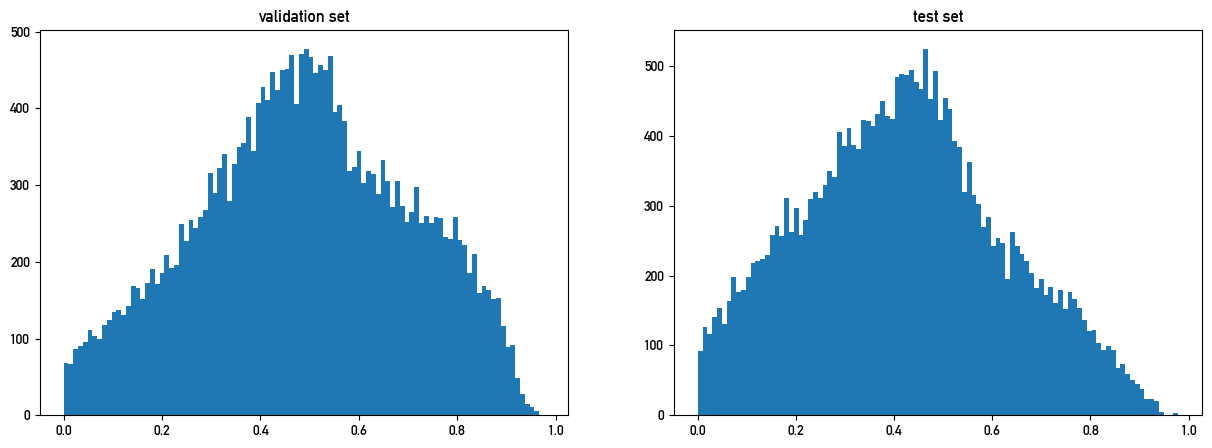

Threshold 1/11 processed.
Threshold 2/11 processed.
Threshold 3/11 processed.
Threshold 4/11 processed.
Threshold 5/11 processed.
Threshold 6/11 processed.
Threshold 7/11 processed.
Threshold 8/11 processed.
Threshold 9/11 processed.
Threshold 10/11 processed.
Threshold 11/11 processed.
Threshold 1/11 processed.
Threshold 2/11 processed.
Threshold 3/11 processed.
Threshold 4/11 processed.
Threshold 5/11 processed.
Threshold 6/11 processed.
Threshold 7/11 processed.
Threshold 8/11 processed.
Threshold 9/11 processed.
Threshold 10/11 processed.
Threshold 11/11 processed.
Raster model successfully loaded.
CNN with 8,893,252 parameters


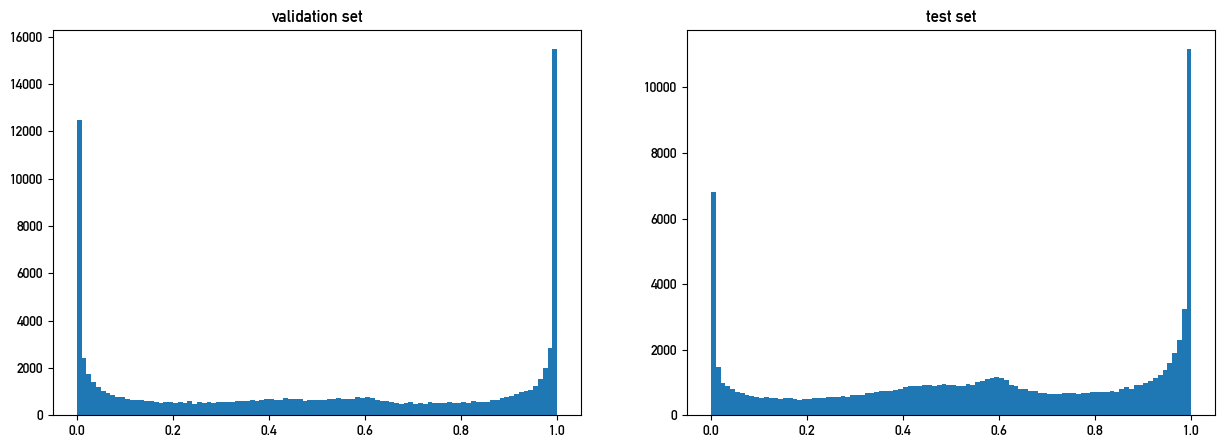

Threshold 1/11 processed.
Threshold 2/11 processed.
Threshold 3/11 processed.
Threshold 4/11 processed.
Threshold 5/11 processed.
Threshold 6/11 processed.
Threshold 7/11 processed.
Threshold 8/11 processed.
Threshold 9/11 processed.
Threshold 10/11 processed.
Threshold 11/11 processed.
Threshold 1/11 processed.
Threshold 2/11 processed.
Threshold 3/11 processed.
Threshold 4/11 processed.
Threshold 5/11 processed.
Threshold 6/11 processed.
Threshold 7/11 processed.
Threshold 8/11 processed.
Threshold 9/11 processed.
Threshold 10/11 processed.
Threshold 11/11 processed.


In [9]:
# elimination model
save_raster_pr_roc(model_filename="CNN_eli_attachRoadsTrue_4075585p_100000s_40ep_bs512_cuda.pth", 
                   interval=interval, 
                   increment=increment)

# multi-operator model
save_raster_pr_roc(model_filename="CNN_sel_attachRoadsTrue_8893252p_100000s_50ep_bs512_cuda.pth", 
                   interval=interval, 
                   increment=increment)

#### Visualization

##### Validation set

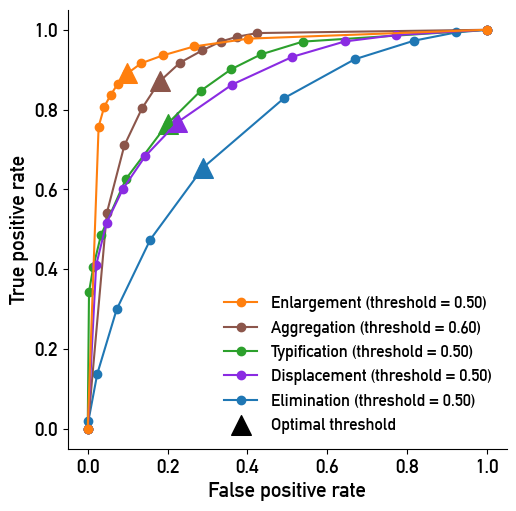

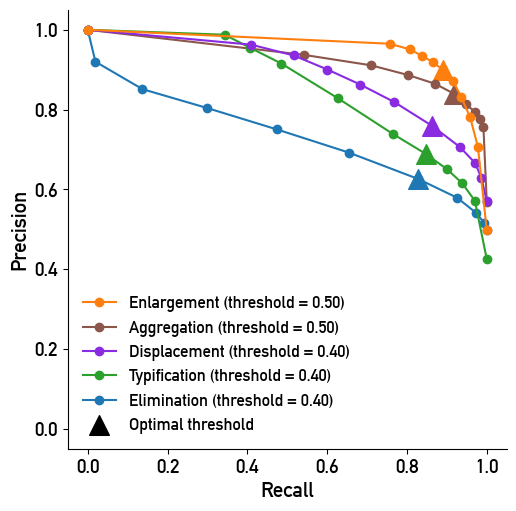

In [9]:
# define paths to PR and ROC CSV files
cnn_validation_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                      "CNN_eli_attachRoadsTrue_4075585p_100000s_40ep_bs512_cuda_validation.csv"),
                         os.path.join(pr_roc_path_selection,
                                      "CNN_sel_attachRoadsTrue_8893252p_100000s_50ep_bs512_cuda_validation.csv")]

# output path
figure_path_cnn_validation_roc = os.path.join(figure_path, "cnn", "validation_roc.png")
figure_path_cnn_validation_pr = os.path.join(figure_path, "cnn", "validation_pr.png")

# legend order
roc_order = ["enlargement", "aggregation", "typification", "displacement", "elimination"]
pr_order = ["enlargement", "aggregation", "displacement", "typification", "elimination"]

# plot the curves
plot_roc_curve(cnn_validation_pr_roc, 
               validation=True, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=True, 
               output_path=figure_path_cnn_validation_roc)
plot_pr_curve(cnn_validation_pr_roc, 
              validation=True, 
              legend_order=pr_order, 
              figsize=(5.7,5.7),
              save=True, 
              output_path=figure_path_cnn_validation_pr)

##### Test set

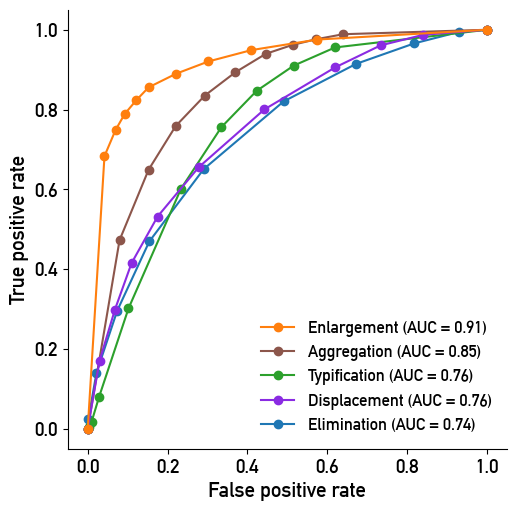

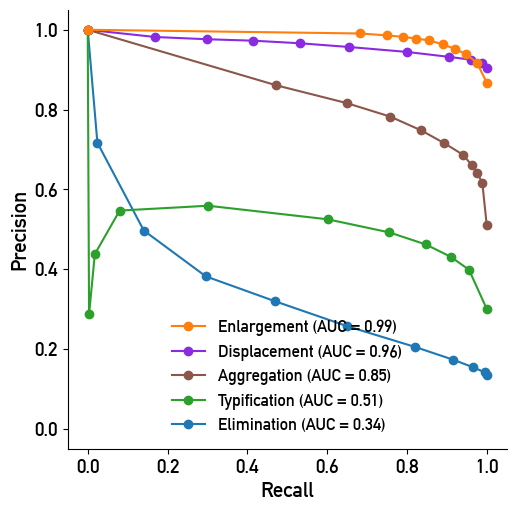

In [10]:
# define paths to PR and ROC CSV files
cnn_test_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                "CNN_eli_attachRoadsTrue_4075585p_100000s_40ep_bs512_cuda_test.csv"),
                   os.path.join(pr_roc_path_selection,
                                "CNN_sel_attachRoadsTrue_8893252p_100000s_50ep_bs512_cuda_test.csv")]

# output path
figure_path_cnn_test_roc = os.path.join(figure_path, "cnn", "test_roc.png")
figure_path_cnn_test_pr = os.path.join(figure_path, "cnn", "test_pr.png")

# legend order
roc_order = ["enlargement", "aggregation", "typification", "displacement", "elimination"]
pr_order = ["enlargement", "displacement", "aggregation", "typification", "elimination"]

# plot the curves
plot_roc_curve(cnn_test_pr_roc, 
               validation=False, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=True, 
               output_path=figure_path_cnn_test_roc)
plot_pr_curve(cnn_test_pr_roc, 
              validation=False, 
              legend_order=pr_order, 
              figsize=(5.7,5.7),
              save=True,
              output_path=figure_path_cnn_test_pr)

### ViT

#### Calculation

Raster model successfully loaded.
Vision Transformer with 20,586,241 parameters


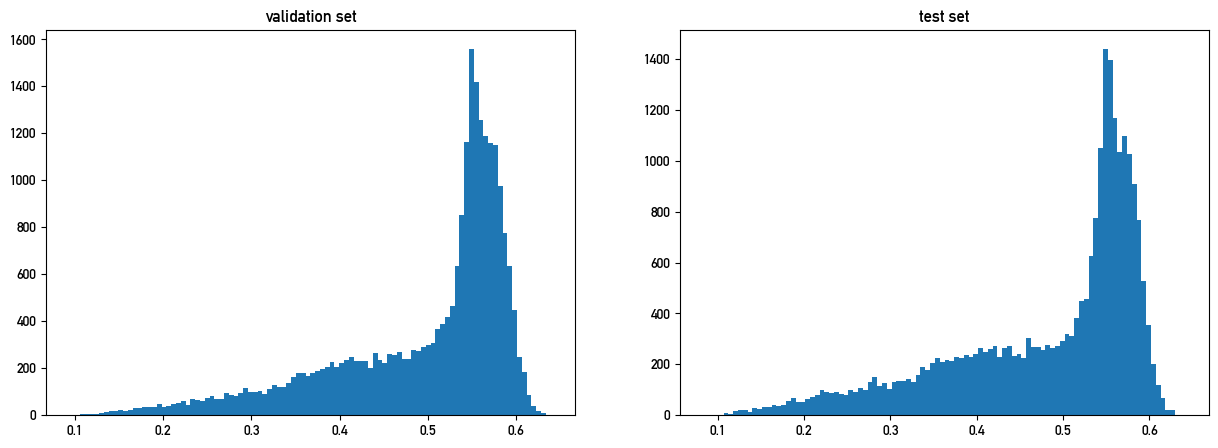

Threshold 1/8 processed.
Threshold 2/8 processed.
Threshold 3/8 processed.
Threshold 4/8 processed.
Threshold 5/8 processed.
Threshold 6/8 processed.
Threshold 7/8 processed.
Threshold 8/8 processed.
Threshold 1/8 processed.
Threshold 2/8 processed.
Threshold 3/8 processed.
Threshold 4/8 processed.
Threshold 5/8 processed.
Threshold 6/8 processed.
Threshold 7/8 processed.
Threshold 8/8 processed.
Raster model successfully loaded.
Vision Transformer with 20,783,620 parameters


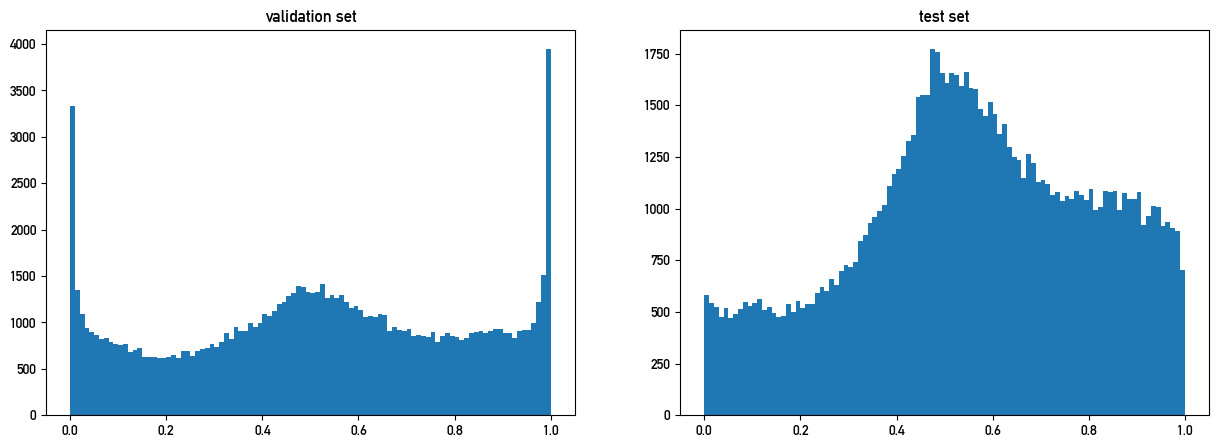

Threshold 1/11 processed.
Threshold 2/11 processed.
Threshold 3/11 processed.
Threshold 4/11 processed.
Threshold 5/11 processed.
Threshold 6/11 processed.
Threshold 7/11 processed.
Threshold 8/11 processed.
Threshold 9/11 processed.
Threshold 10/11 processed.
Threshold 11/11 processed.
Threshold 1/11 processed.
Threshold 2/11 processed.
Threshold 3/11 processed.
Threshold 4/11 processed.
Threshold 5/11 processed.
Threshold 6/11 processed.
Threshold 7/11 processed.
Threshold 8/11 processed.
Threshold 9/11 processed.
Threshold 10/11 processed.
Threshold 11/11 processed.


In [12]:
# elimination model
save_raster_pr_roc(model_filename="ViT_eli_attachRoadsTrue_20586241p_100000s_100ep_bs512_cuda.pth", 
                   interval=(0,0.7), 
                   increment=increment)

# multi-operator model
save_raster_pr_roc(model_filename="ViT_sel_attachRoadsTrue_20783620p_100000s_90ep_bs512_cuda.pth", 
                   interval=interval, 
                   increment=increment)

#### Visualization

##### Validation set

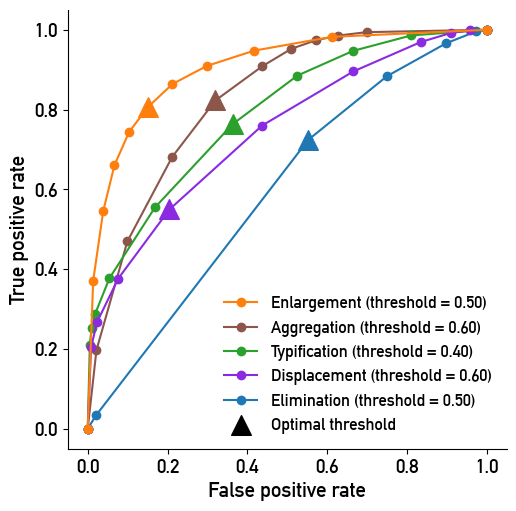

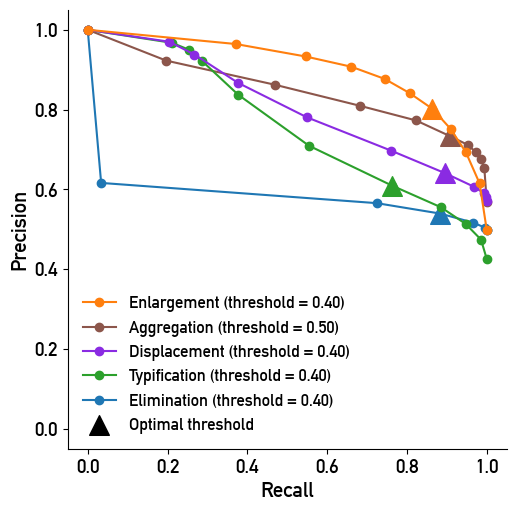

In [11]:
# define paths to PR and ROC CSV files
vit_validation_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                      "ViT_eli_attachRoadsTrue_20586241p_100000s_100ep_bs512_cuda_validation.csv"),
                         os.path.join(pr_roc_path_selection,
                                      "ViT_sel_attachRoadsTrue_20783620p_100000s_90ep_bs512_cuda_validation.csv")]

# output path
figure_path_vit_validation_roc = os.path.join(figure_path, "vit", "validation_roc.png")
figure_path_vit_validation_pr = os.path.join(figure_path, "vit", "validation_pr.png")

# legend order
roc_order = ["enlargement", "aggregation", "typification", "displacement", "elimination"]
pr_order = ["enlargement", "aggregation", "displacement", "typification", "elimination"]

# plot the curves
plot_roc_curve(vit_validation_pr_roc, 
               validation=True, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=True, 
               output_path=figure_path_vit_validation_roc)
plot_pr_curve(vit_validation_pr_roc, 
              validation=True, 
              legend_order=pr_order,
              figsize=(5.7,5.7),
              save=True, 
              output_path=figure_path_vit_validation_pr)

##### Test set

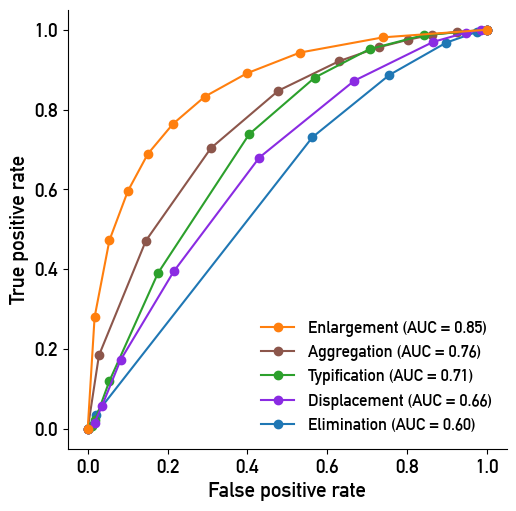

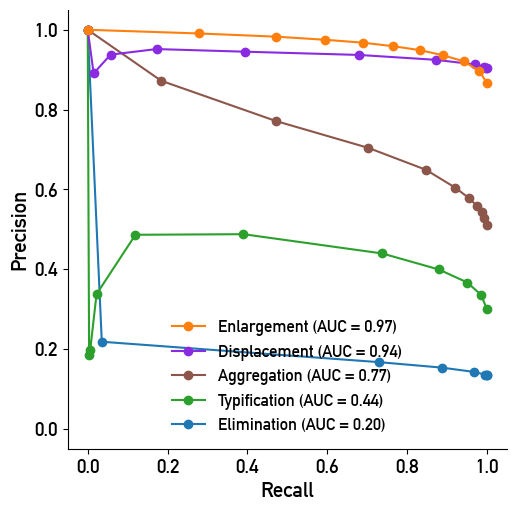

In [12]:
# define paths to PR and ROC CSV files
vit_test_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                "ViT_eli_attachRoadsTrue_20586241p_100000s_100ep_bs512_cuda_test.csv"),
                   os.path.join(pr_roc_path_selection,
                                "ViT_sel_attachRoadsTrue_20783620p_100000s_90ep_bs512_cuda_test.csv")]

# output path
figure_path_vit_test_roc = os.path.join(figure_path, "vit", "test_roc.png")
figure_path_vit_test_pr = os.path.join(figure_path, "vit", "test_pr.png")

# legend order
roc_order = ["enlargement", "aggregation", "typification", "displacement", "elimination"]
pr_order = ["enlargement", "displacement", "aggregation", "typification", "elimination"]

# plot the curves
plot_roc_curve(vit_test_pr_roc, 
               validation=False, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=True, 
               output_path=figure_path_vit_test_roc)
plot_pr_curve(vit_test_pr_roc, 
              validation=False, 
              legend_order=pr_order, 
              figsize=(5.7,5.7),
              save=True, 
              output_path=figure_path_vit_test_pr)

## Accuracy metrics

### CNN

#### Elimination model

Raster model successfully loaded.
CNN with 4,075,585 parameters


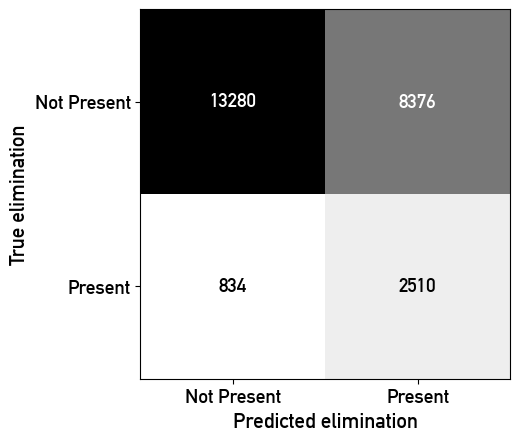

Accuracy: 0.632
Precision: 0.231
Recall: 0.751
F1 Score: 0.353


In [8]:
compute_raster_evaluation_metrics("CNN_eli_attachRoadsTrue_4075585p_100000s_40ep_bs512_cuda.pth")

#### Multi-operator model

Raster model successfully loaded.
CNN with 8,893,252 parameters


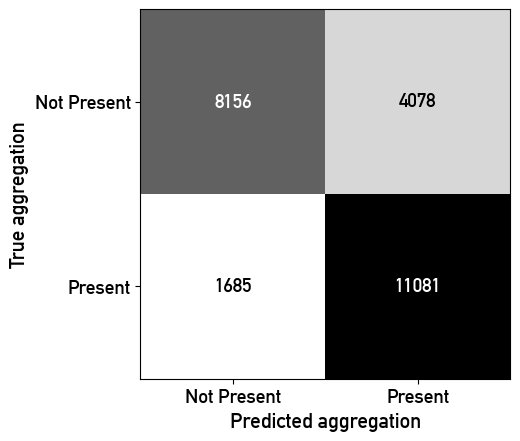

Accuracy: 0.769
Precision: 0.731
Recall: 0.868
F1 Score: 0.794


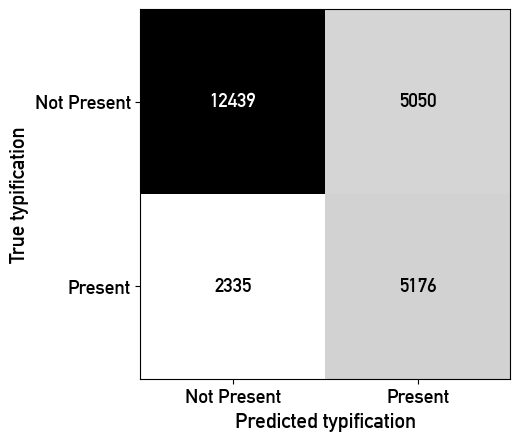

Accuracy: 0.705
Precision: 0.506
Recall: 0.689
F1 Score: 0.584


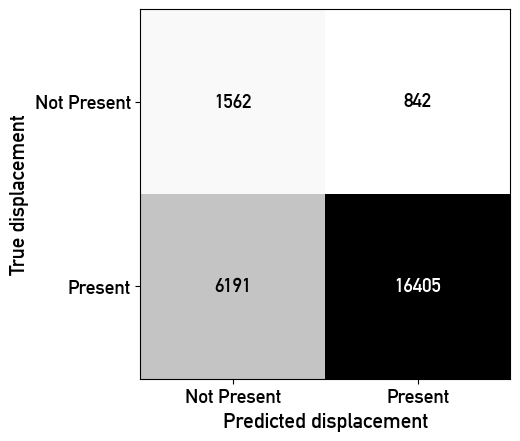

Accuracy: 0.719
Precision: 0.951
Recall: 0.726
F1 Score: 0.823


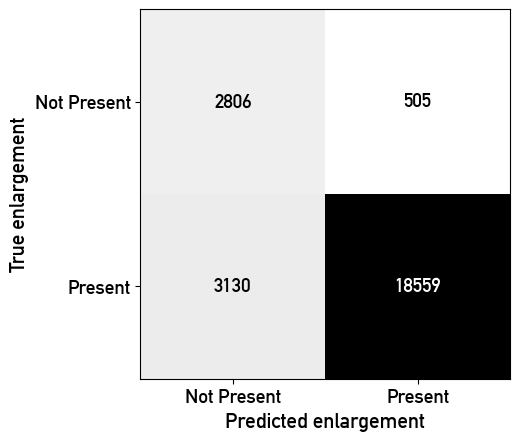

Accuracy: 0.855
Precision: 0.974
Recall: 0.856
F1 Score: 0.911


In [9]:
compute_raster_evaluation_metrics("CNN_sel_attachRoadsTrue_8893252p_100000s_50ep_bs512_cuda.pth")

### ViT

#### Elimination model

Raster model successfully loaded.
Vision Transformer with 20,586,241 parameters


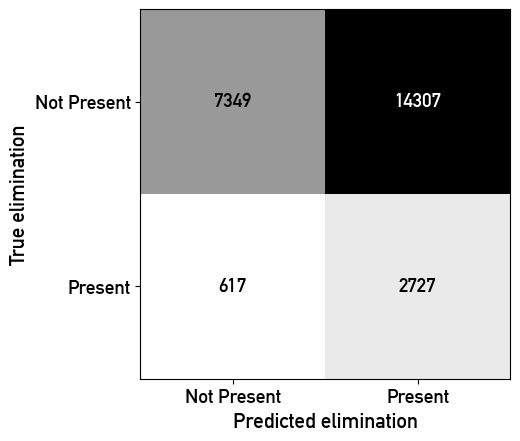

Accuracy: 0.403
Precision: 0.160
Recall: 0.815
F1 Score: 0.268


In [10]:
compute_raster_evaluation_metrics("ViT_eli_attachRoadsTrue_20586241p_100000s_100ep_bs512_cuda.pth")

#### Multi-operator model

Raster model successfully loaded.
Vision Transformer with 20,783,620 parameters


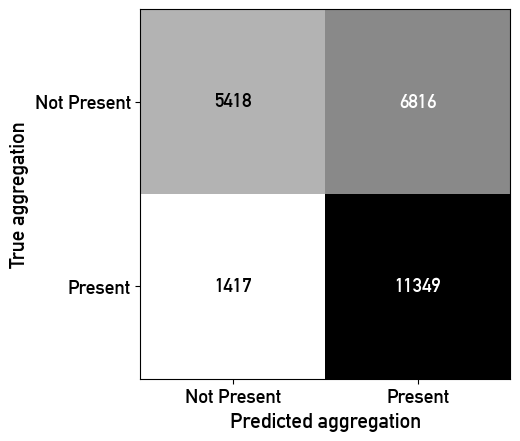

Accuracy: 0.671
Precision: 0.625
Recall: 0.889
F1 Score: 0.734


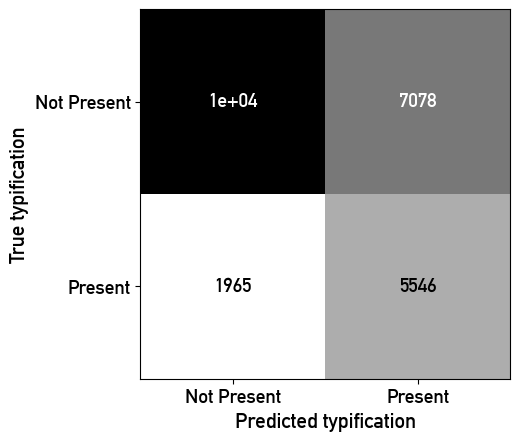

Accuracy: 0.638
Precision: 0.439
Recall: 0.738
F1 Score: 0.551


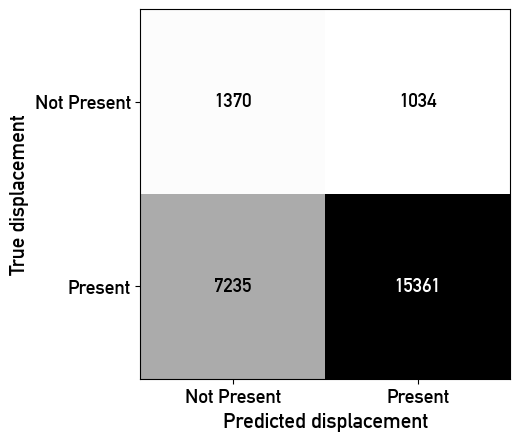

Accuracy: 0.669
Precision: 0.937
Recall: 0.680
F1 Score: 0.788


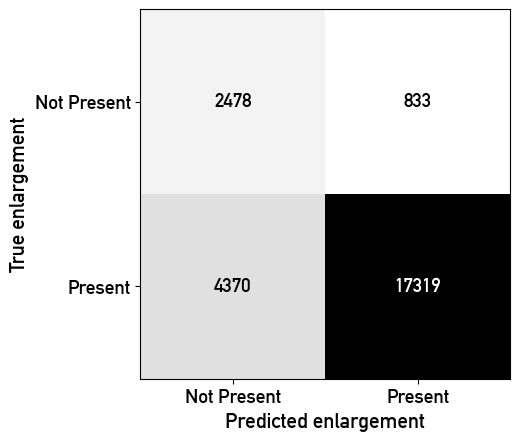

Accuracy: 0.792
Precision: 0.954
Recall: 0.799
F1 Score: 0.869


In [11]:
compute_raster_evaluation_metrics("ViT_sel_attachRoadsTrue_20783620p_100000s_90ep_bs512_cuda.pth")

### Excluding the roads

#### Calculate ROC and PR curves

Raster model successfully loaded.
CNN with 4,067,841 parameters


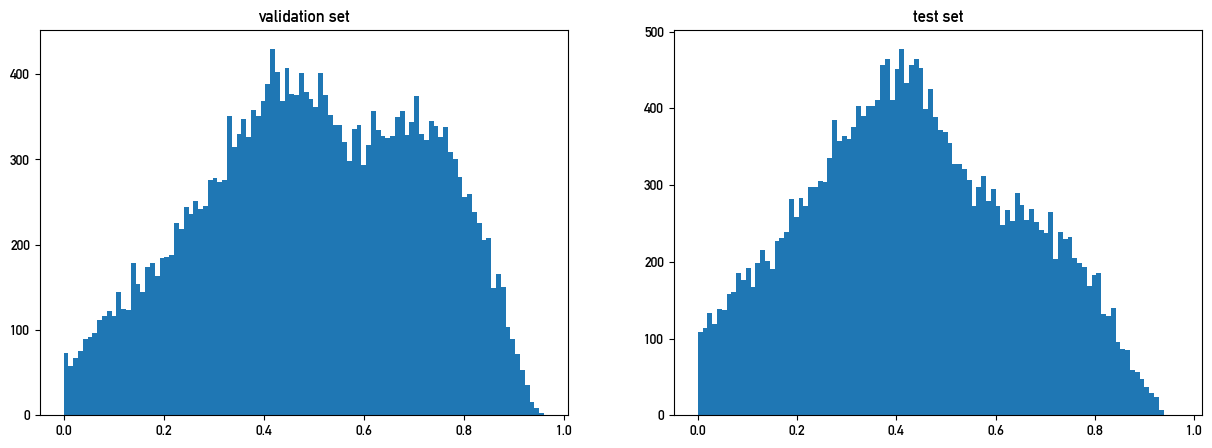

Threshold 1/11 processed.
Threshold 2/11 processed.
Threshold 3/11 processed.
Threshold 4/11 processed.
Threshold 5/11 processed.
Threshold 6/11 processed.
Threshold 7/11 processed.
Threshold 8/11 processed.
Threshold 9/11 processed.
Threshold 10/11 processed.
Threshold 11/11 processed.
Threshold 1/11 processed.
Threshold 2/11 processed.
Threshold 3/11 processed.
Threshold 4/11 processed.
Threshold 5/11 processed.
Threshold 6/11 processed.
Threshold 7/11 processed.
Threshold 8/11 processed.
Threshold 9/11 processed.
Threshold 10/11 processed.
Threshold 11/11 processed.
Raster model successfully loaded.
CNN with 8,885,508 parameters


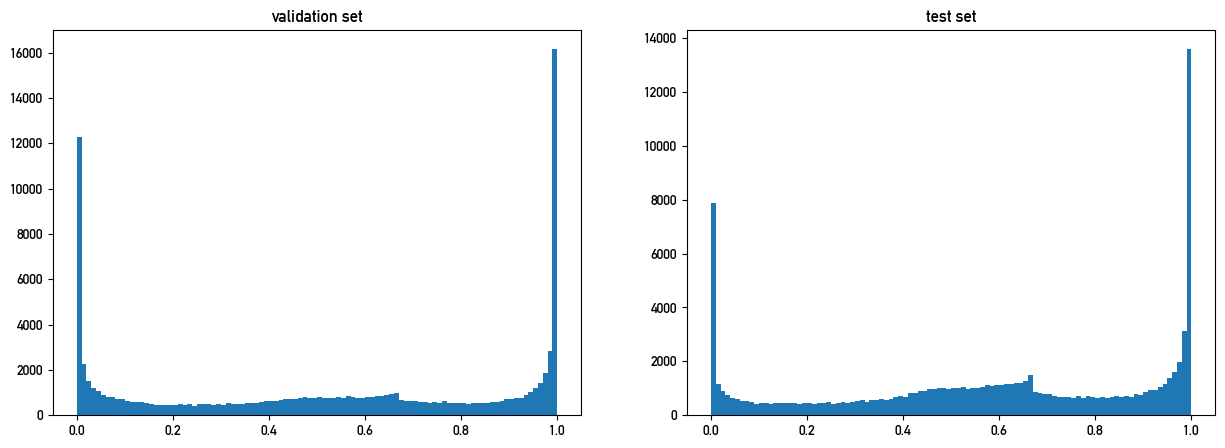

Threshold 1/11 processed.
Threshold 2/11 processed.
Threshold 3/11 processed.
Threshold 4/11 processed.
Threshold 5/11 processed.
Threshold 6/11 processed.
Threshold 7/11 processed.
Threshold 8/11 processed.
Threshold 9/11 processed.
Threshold 10/11 processed.
Threshold 11/11 processed.
Threshold 1/11 processed.
Threshold 2/11 processed.
Threshold 3/11 processed.
Threshold 4/11 processed.
Threshold 5/11 processed.
Threshold 6/11 processed.
Threshold 7/11 processed.
Threshold 8/11 processed.
Threshold 9/11 processed.
Threshold 10/11 processed.
Threshold 11/11 processed.


In [8]:
# interval and increment for the calculation
interval = (0,1)
increment = 0.1

# elimination model
save_raster_pr_roc(model_filename="CNN_eli_attachRoadsFalse_4067841p_100000s_40ep_bs512_cuda.pth", 
                   interval=interval, 
                   increment=increment)

# multi-operator model
save_raster_pr_roc(model_filename="CNN_sel_attachRoadsFalse_8885508p_100000s_50ep_bs512_cuda.pth", 
                   interval=interval, 
                   increment=increment)

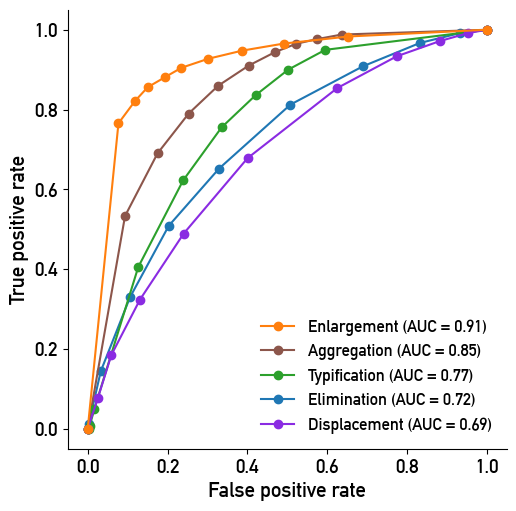

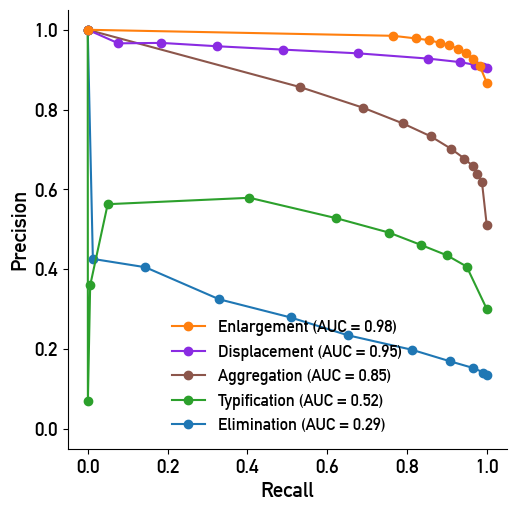

In [8]:
# define paths to saved PR and ROC files
pr_roc_path_elimination = os.path.join(raster_path, "model_outputs", "elimination", "pr_roc")
pr_roc_path_selection = os.path.join(raster_path, "model_outputs", "selection", "pr_roc")

# define paths to PR and ROC CSV files
cnn_no_roads_test_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                         "CNN_eli_attachRoadsFalse_4067841p_100000s_40ep_bs512_cuda_test.csv"),
                            os.path.join(pr_roc_path_selection,
                                         "CNN_sel_attachRoadsFalse_8885508p_100000s_50ep_bs512_cuda_test.csv")]

# legend order
roc_order = ["enlargement", "aggregation", "typification", "elimination", "displacement"]
pr_order = ["enlargement", "displacement", "aggregation", "typification", "elimination"]

# plot the curves
plot_roc_curve(cnn_no_roads_test_pr_roc, 
               validation=False, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=False)
plot_pr_curve(cnn_no_roads_test_pr_roc, 
              validation=False, 
              legend_order=pr_order, 
              figsize=(5.7,5.7),
              save=False)